# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

**План работы над проектом**
1. Загрузка и подготовка данных
2. Обучение и проверка модели
3. Подготовка к расчету прибыли (убытка)
4. Расчет прибыли (убытка)
5. Выводы по проекту
6. Чек-лист готовности проекта

## Загрузка и подготовка данных

### Загрузка библиотек

In [1]:
# Загрузим необходимые библиотеки
!pip install shap -q
!pip install scikit-learn==1.1.3 -q
!pip -q install phik

In [2]:
# Импортируем необходимые нам библиотеки
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from scipy import stats as st
from scipy.stats import binom, norm, spearmanr
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, 
    mean_squared_error, 
    mean_absolute_error, 
    accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score, 
    roc_auc_score, 
    f1_score,
    make_scorer
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC

import shap

### Загрузка данных

In [3]:
# Загрузим данные тренировочной выборки /datasets/geo_data_0.csv, выбрав верный разделитель. 
# Ознакомимся с содержимым.
geo_data_0 = pd.read_csv('/datasets//geo_data_0.csv', sep = ',', decimal='.')
geo_data_0.info()
geo_data_0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [4]:
# Загрузим данные тренировочной выборки /datasets/geo_data_1.csv, выбрав верный разделитель. 
# Ознакомимся с содержимым.
geo_data_1 = pd.read_csv('/datasets//geo_data_1.csv', sep = ',', decimal='.')
geo_data_1.info()
geo_data_1.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [5]:
# Загрузим данные тренировочной выборки /datasets/geo_data_2.csv, выбрав верный разделитель. 
# Ознакомимся с содержимым.
geo_data_2 = pd.read_csv('/datasets//geo_data_2.csv', sep = ',', decimal='.')
geo_data_2.info()
geo_data_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


Данные загрузились корректно. Разделитель выбран верно. Все три датасета содержат 10 000 строк и 5 столбцов. Явных пропусков нет.

### Предобработка данных

In [6]:
# Проверим данные на наличие дубликатов 'id'
print(geo_data_0.duplicated(['id']).sum())
print(geo_data_1.duplicated(['id']).sum())
print(geo_data_2.duplicated(['id']).sum())

10
4
4


Выявлено незначительное количество дубликатов в скважинах. Удалим их.

In [7]:
# Удаляем дубликаты 'id'
geo_data_0 = geo_data_0.drop_duplicates('id')
geo_data_1 = geo_data_1.drop_duplicates('id')
geo_data_2 = geo_data_2.drop_duplicates('id')

In [8]:
# Проверим еще раз данные на наличие дубликатов 'id'
print(geo_data_0.duplicated(['id']).sum())
print(geo_data_1.duplicated(['id']).sum())
print(geo_data_2.duplicated(['id']).sum())

0
0
0


На этом предобработку данных можно завершить, т.к. кроме 'id' скважин остальные данные у нас вещественные, с ними будем разбираться в исследовательском анализе.

### Исследовательский анализ данных

In [9]:
# Создадим функцию вывода гистограммы распределения для числовых данных
def hist_num (data):
    plt.figure(figsize=(20, 10))
    plt.subplot(2, 2, 1)
    data['f0'].plot(kind = 'hist', grid=True)
    plt.title('Распределение признака f0')
    plt.ylabel('Частота')
    plt.xlabel('f0')
    plt.subplot(2, 2, 2)
    data['f1'].plot(kind = 'hist', grid=True)
    plt.title('Распределение признака f1')
    plt.ylabel('Частота')
    plt.xlabel('f1')
    plt.subplot(2, 2, 3)
    data['f2'].plot(kind = 'hist', grid=True)
    plt.title('Распределение признака f2')
    plt.ylabel('Частота')
    plt.xlabel('f2')
    plt.subplot(2, 2, 4)
    data['product'].plot(kind = 'hist', grid=True)
    plt.title('Распределение целевого признака product')
    plt.ylabel('Частота')
    plt.xlabel('product')
    plt.show()

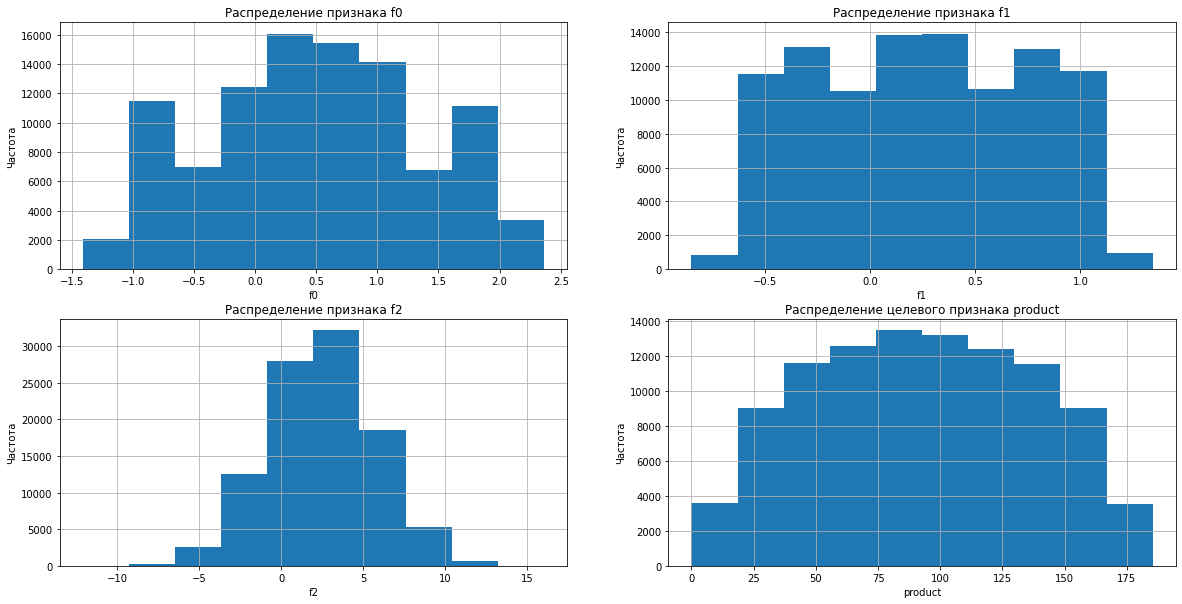

In [10]:
# Выведем распределения данных в датасете 'geo_data_0'
data=geo_data_0
hist_num(data)

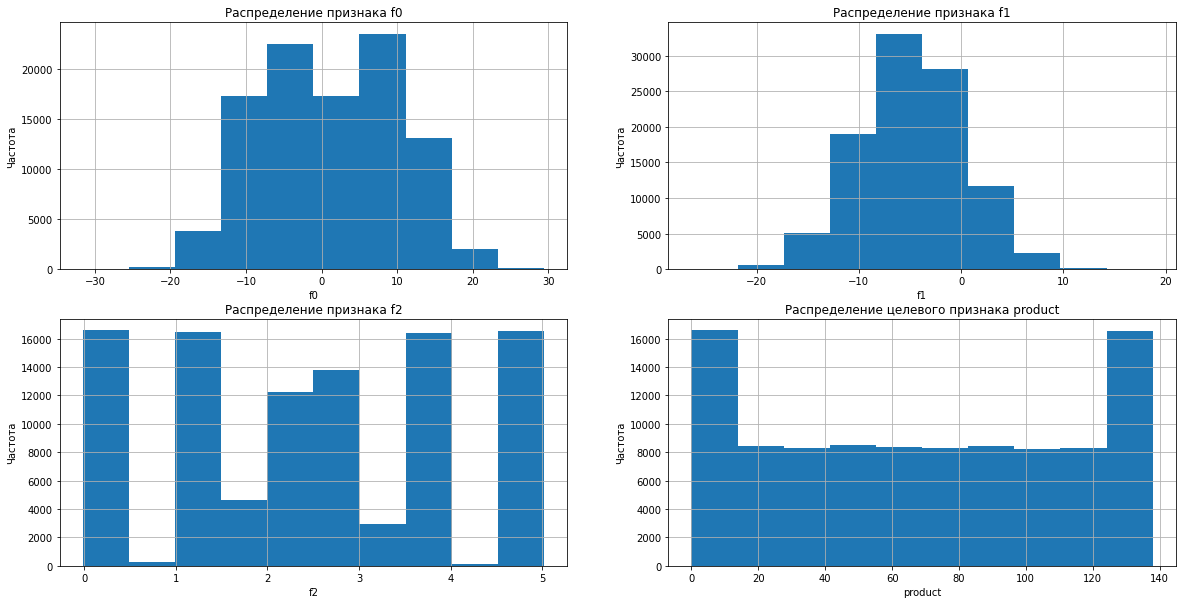

In [11]:
# Выведем распределения данных в датасете 'geo_data_1'
data=geo_data_1
hist_num(data)

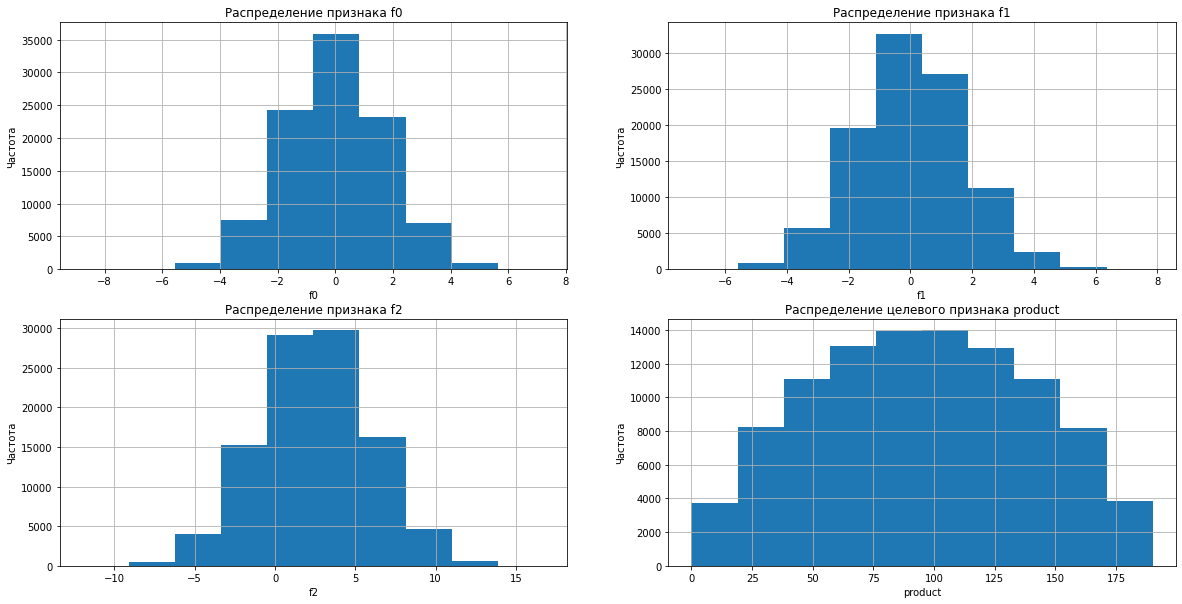

In [12]:
# Выведем распределения данных в датасете 'geo_data_2'
data=geo_data_2
hist_num(data)

Распределения данных во всех трех датасетах схожие и близки к нормальным. Непривычный вид распределения признака 'f2' в датасете 'geo_data_1' объясняется малым разбросом в данных этого признака по сравнению с аналогичными параметрами в других датасетах.

<br>
Также отметим полное отсутсвие выбросов и других аномалий в данных. Таким образом, данные готовы к этапу моделирования.

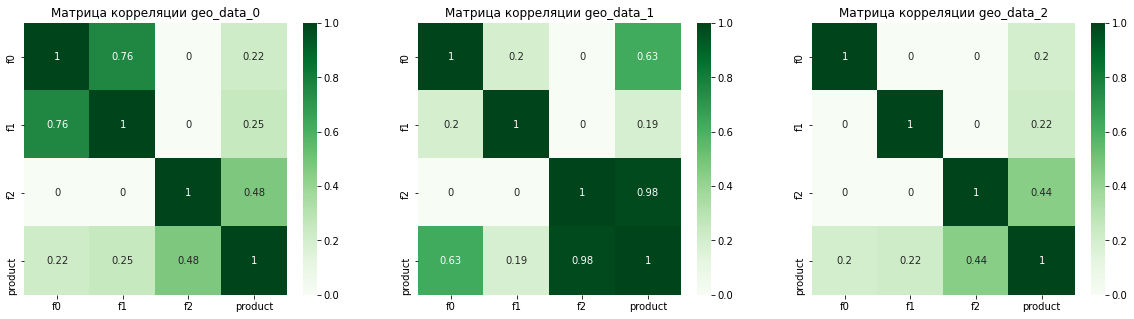

In [13]:
# Выведем матрицы корреляции по всем датасетам
target_matrix_0 = geo_data_0.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
target_matrix_1 = geo_data_1.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
target_matrix_2 = geo_data_2.drop('id', axis=1).phik_matrix(interval_cols=['f0', 'f1', 'f2', 'product'])
plt.figure(figsize=(20, 5))
plt.subplot(1,3,1)
sns.heatmap(target_matrix_0, annot=True, cmap='Greens')
plt.title('Матрица корреляции geo_data_0')
plt.subplot(1,3,2)
sns.heatmap(target_matrix_1, annot=True, cmap='Greens')
plt.title('Матрица корреляции geo_data_1')
plt.subplot(1,3,3)
sns.heatmap(target_matrix_2, annot=True, cmap='Greens')
plt.title('Матрица корреляции geo_data_2')
plt.show()

С целевым признаком наилучшая корреляция у параметра 'f2', с коэффициентом от 0.44 до 0.98. В датасете geo_data_1 помимо высокого коэффициента корреляции 0.98 у 'f2', с целевым признаком также коррелируется параметр 'f0' с коэффициентом 0.63.
<br>
На этом исследовательский анализ можно завершить.

## Обучение и проверка модели

### Создание функции для обучения и проверки модели

In [14]:
# Создадим функцию для обучения и проверки модели
def modeling (data):
    # Фиксируем константы
    RANDOM_STATE = 42
    TEST_SIZE = 0.25

    # Делим датасет на тренировочную и валидационную выборки
    X_train, X_valid, y_train, y_valid = train_test_split(
        data.drop(['product', 'id'], axis=1),
        data['product'],
        test_size = TEST_SIZE, 
        random_state = RANDOM_STATE)

    # Стандартизируем данные используя StandardScaler()
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_std = scaler.transform(X_train)
    X_valid_std = scaler.transform(X_valid)

    # Обучаем модель
    model = LinearRegression()
    model.fit(X_train_std, y_train)

    # Выводим предсказания обученной моделью
    predictions = model.predict(X_valid_std)
    
    # Сохраним необходимые нам результаты
    RMSE = mean_squared_error(y_valid, predictions, squared=False)
    targets = y_valid
    
    print('RMSE на валидационной выборке: {}'.format(round(RMSE, 2)))
    print('Средний запас на скважину, предсказание: {} тыс.баррелей'.format(round(predictions.mean(), 2)))
    return RMSE, predictions, targets

### Обучение и проверка модели на трех регионах добычи

In [15]:
# Прогоним данные первого региона через нашу модель, выведем и сохраним результаты
RMSE_1, pred_1, targets_1 = modeling(geo_data_0)

RMSE на валидационной выборке: 37.69
Средний запас на скважину, предсказание: 92.61 тыс.баррелей


In [16]:
# Прогоним данные второго региона через нашу модель, выведем и сохраним результаты
RMSE_2, pred_2, targets_2 = modeling(geo_data_1)

RMSE на валидационной выборке: 0.89
Средний запас на скважину, предсказание: 68.58 тыс.баррелей


In [17]:
# Прогоним данные третьего региона через нашу модель, выведем и сохраним результаты
RMSE_3, pred_3, targets_3 = modeling(geo_data_2)

RMSE на валидационной выборке: 40.08
Средний запас на скважину, предсказание: 94.93 тыс.баррелей


Наилучшие результаты (точность модели) мы получили при работе с данными второго региона. Это неудивительно, учитывая практически линейную связь (0,98) признака 'f2' с целевым признаком для данного региона.

## Подготовка к расчёту прибыли

In [18]:
# Создадим константы Python
budget = 10000000000
profit_per_1000_barrel = 450000
loss_threshold = 0.025

In [19]:
# Посчитаем минимальное среднее количество продукта в месторождениях региона, достаточное для разработки.
min_value_for_development = (budget / 200) / profit_per_1000_barrel
print("Минимальное среднее количество запасов продукта на скважину: {} тыс.баррелей".format(round(min_value_for_development, 2)))

Минимальное среднее количество запасов продукта на скважину: 111.11 тыс.баррелей


Минимальная рентабельность разработки достигается при средних извекаемых запасов в 111.11 тыс.баррелей на скважину. При бюджете 10 млрд.рублей, строительстве 200 новых скважин на регион и текущей рыночной коньюктуре.

In [20]:
# Выведем средний запас на скважину для каждого региона
print('Средний запас на скважину первого региона: {} тыс.баррелей'.format(round(geo_data_0['product'].mean(), 2)))
print('Средний запас на скважину второго региона: {} тыс.баррелей'.format(round(geo_data_1['product'].mean(), 2)))
print('Средний запас на скважину третьего региона: {} тыс.баррелей'.format(round(geo_data_2['product'].mean(), 2)))

Средний запас на скважину первого региона: 92.5 тыс.баррелей
Средний запас на скважину второго региона: 68.82 тыс.баррелей
Средний запас на скважину третьего региона: 95.0 тыс.баррелей


По всем трем регионам в среднем на скважину не достигается необходимый уровень запасов для минимальной рентабельности. Но это в среднем, нам же нужно отобрать 200 лучших скважин по предсказанному уровню запасов. Рассчитаем средний запас на скважину для 200 лучших скважин и вычтем минимальный рентабельный уровень запасов. 

In [21]:
# Напишим функцию для расчета прибыли на скважину для каждого региона
def profit_func(target, predict):
    pred_top_200 = pd.Series(predict).sort_values(ascending=False)[:200]
    targets_top_200 = (target.reset_index(drop = True)[pred_top_200.index])
    true_sum = targets_top_200.sum()
    return round((true_sum * profit_per_1000_barrel) - budget, 2)

In [22]:
# Рассчитаем потенциальную среднюю прибыль 200 новых скважин (лучших по результатам моделирования) для каждого региона
print('Потенциальная средняя прибыль со скважины первого региона: {}'.format(round(profit_func(targets_1, pred_1), 2)))
print('Потенциальная средняя прибыль со скважины второго региона: {}'.format(round(profit_func(targets_2, pred_2), 2)))
print('Потенциальная средняя прибыль со скважины третьего региона: {}'.format(round(profit_func(targets_3, pred_3), 2)))

Потенциальная средняя прибыль со скважины первого региона: 3468529787.42
Потенциальная средняя прибыль со скважины второго региона: 2415086696.68
Потенциальная средняя прибыль со скважины третьего региона: 2396613000.94


Если оперировать средними значениями запасов в 200 лучших новых скважинах, то по всем трем регионам средняя прибыль положительная с учетом текущей рыночной коньюктуры. Однако, нам необходимо также оценить вероятность прибыльности/убыточности и оставить лишь те регионы, в которых вероятность убытков меньше 2.5%. Для этого воспользуемся расчетом доверительного интервала 95%, нижняя граница которого как раз составляет 2,5%.

In [23]:
# Напишим функцию для расчета прибыли по результатам подвыборок (Bootstrap,1000 выборок, 500 скважин)
def profit_bootstrap(target, predict):
    # Фиксируем начение для random_state
    state = np.random.RandomState(42)
    # Создаем список прибыли/убытка для bootstrep
    profit_values = []
    for i in range(1000):
        subsample = pd.Series(predict).sample(500, replace=True, random_state = state)
        profit_values.append(profit_func(target, subsample))
    profit_values = pd.Series(profit_values)
    # Рассчитаем границы доверительного интервала 95%
    bot_interval = profit_values.quantile(0.025)
    top_interval = profit_values.quantile(0.975)
    print('Средняя прибыль ТОП 200 скважин:{}'.format(round(profit_values.mean(), 2)))
    print('Риск убытков:{}%'.format(round((profit_values.apply(lambda x: x < 0).sum()/len(profit_values)*100), 2)))
    print(f'Доверительный интервал 95%:{round(bot_interval,2)} ... {round(top_interval,2)}')
    

## Расчёт прибыли и рисков 

Применим технику Bootstrap с 1000 выборок вызвав соответсвующую функцию для каждого региона

In [24]:
print(f'Регион_1')
profit_bootstrap(targets_1, pred_1)

Регион_1
Средняя прибыль ТОП 200 скважин:403572063.95
Риск убытков:5.9%
Доверительный интервал 95%:-137690003.15 ... 902848310.77


In [25]:
print(f'Регион_2')
profit_bootstrap(targets_2, pred_2)

Регион_2
Средняя прибыль ТОП 200 скважин:430208352.49
Риск убытков:1.6%
Доверительный интервал 95%:43052519.63 ... 847313467.21


In [26]:
print(f'Регион_3')
profit_bootstrap(targets_3, pred_3)

Регион_3
Средняя прибыль ТОП 200 скважин:384214428.68
Риск убытков:8.0%
Доверительный интервал 95%:-127589876.99 ... 910134439.54


95% доверительный интервал региона 1 и 3 своей нижней границей заходит в зону отрицательной прибыли (зона убытков), формируя таким образом вероятность убытков в 5.9% и 8.0% соответственно. 
<br>
Регион 2 - наоборот, доверительный интервал целиком лежит в зоне прибыли, а вероятность убытков составляет всего 1.6%, что ниже нашего граничного значения в 2.5% для нашего инвестиционного проекта.
<br>
Таким образом, единственный регион рекомендуемый к разработке в рамках нашего инвестиционного проекта - Регион 2.

## Выводы по проекту

Для работы над проектом мы получили данные по трем регионам добычи. Регионы 1 и 3 имеют схожие распределения признаков f* и более высокий средний запас продукции на скважину в сравнии с регионом 2. Регион 2 также отличается от остальных малым разбросом и практически прямой зависимостью признака f2 с общим запасом продукции на скважину.
<br>
В ходе работы мы ознакомились с данными и удалили явные дубликаты. Затем, мы провели исследовательский анализ данных и отметили для себя некоторые особенности в данных Региона 2. Для работы с моделью (применяли линейную регрессию) мы подготовили отдельную функцию обеспечивающую обучение и проверку модели метрикой RMSE, вывод и сохранение необходимых нам предсказаний. На выходе получили минимальную ошибку RMSE для данных Региона 2 и довольно существенную RMSE на данных остальных регионов.
<br>
Далее мы подготовили функции расчета прибыли и bootstrap с 1000 подвыборок для расчета средней прибыли, риска убытка и 95% доверительного интервала. Затем применили их на наших данных по трем регионам.
<br>
Проанализировав результаты мы пришли к заключению, что единственным регионом рекомендуемым нами к разработке в рамках  инвестиционного проекта это Регион 2. Так как, только он обеспечивает вероятность риска убытков менее 2.5%, несмотря на более низкие запасы продукции на скважину.
<br>
Для реализации аналогичного инвестиционного проекта на остальных регионах, рекомендуется сократить количество планируемых новых скважин, тем самым обеспечить снижение риска убытков до приемлемого уровня. Также необходимо изыскать дополнительные входные признаки, имеющие более тесную связь с продуктивностью скважин в данных регионах, что в свою очередь позволит снизить RMSE и повысить точность предсказаний модели.